In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'top-box-office-revenue-data-english-movies:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1957321%2F8574279%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240601%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240601T161658Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D79aff47546c5cfe41c88975e1ed570d9700330cb82d968eed1a97a99f21c4cd1d49a76d2a943e6e8911ad38d35248430ea5a7f00c72737ca56a9ee66ef6cfc5c86da8e3b0807759606fce935c39144db8a9d5fe56b27a4e3e6d239064b57f4b3b7c4c446fca1cc55bc4861c006559f5152fd16d37ea6bff6ae677df935d255dabd10d9987b366510d62759e648dbd3259e02298c55e49546e17dd04cebbd53f0087a8db002eab666ba85f8dd7540be5977feb43bed88ef0cef9c9693990eac74cc9cf794b640f4fa00be6f8b9ddb504fee56fd1ceb62bd8c4b7587ddd44d64abd1b634a37b007c52d15135b4b5424e14b22ef66dac52d20e7422d2d0dc5c43b5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 68252 bytes downloaded
Downloaded and uncompressed: top-box-office-revenue-data-english-movies
Data source import complete.


# **Постановка задачи**

Определить наиболее успешную франшизу по выручке на один фильм и сделать вывод, какой тип франшизы наиболее привлекателен потенциально (комиксы, мультфильмы и т. п.)

In [2]:
import numpy as np
import pandas as pd
import os


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/top-box-office-revenue-data-english-movies/boxofficemojobrandindices.tsv
/kaggle/input/top-box-office-revenue-data-english-movies/boxofficemojotopgenres.tsv
/kaggle/input/top-box-office-revenue-data-english-movies/boxofficemojoustop1000.tsv
/kaggle/input/top-box-office-revenue-data-english-movies/boxofficemojointernationaltop1000.tsv
/kaggle/input/top-box-office-revenue-data-english-movies/boxofficemojotopfranchises.tsv
/kaggle/input/top-box-office-revenue-data-english-movies/bomojobrandindices.csv


In [3]:
df = pd.read_csv('/kaggle/input/top-box-office-revenue-data-english-movies/boxofficemojotopfranchises.tsv', delimiter='\t')
df.head(3)

,Franchise,Total,Releases,#1 Release,Lifetime Gross
0,Marvel Cinematic Universe,9892046843,30,Avengers: Endgame,858373000
1,Star Wars,5081703177,21,Star Wars: Episode VII - The Force Awakens,936662225
2,Disney Live Action Reimaginings,3493794115,17,The Lion King,543638043


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Franchise       292 non-null    object
 1   Total           292 non-null    int64 
 2   Releases        292 non-null    int64 
 3   #1 Release      292 non-null    object
 4   Lifetime Gross  292 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 11.5+ KB


Все ячейки имеют правильный тип данных

# **Обработка данных**

In [5]:
df.rename(columns={'#1 Release':'First film'}, inplace=True)
df.head(3)

,Franchise,Total,Releases,First film,Lifetime Gross
0,Marvel Cinematic Universe,9892046843,30,Avengers: Endgame,858373000
1,Star Wars,5081703177,21,Star Wars: Episode VII - The Force Awakens,936662225
2,Disney Live Action Reimaginings,3493794115,17,The Lion King,543638043


In [6]:
df.drop(columns=['Lifetime Gross'], axis=1, inplace=True)
df.head(3)

,Franchise,Total,Releases,First film
0,Marvel Cinematic Universe,9892046843,30,Avengers: Endgame
1,Star Wars,5081703177,21,Star Wars: Episode VII - The Force Awakens
2,Disney Live Action Reimaginings,3493794115,17,The Lion King


In [7]:
# Переведём значения в столбце Total в миллиарды
df['Total'] = (df['Total'] / (np.power(10, 9))).round(2)
df.rename(columns={'Total': 'Total (billions)'}, inplace=True)
df.head(3)

,Franchise,Total (billions),Releases,First film
0,Marvel Cinematic Universe,9.89,30,Avengers: Endgame
1,Star Wars,5.08,21,Star Wars: Episode VII - The Force Awakens
2,Disney Live Action Reimaginings,3.49,17,The Lion King


In [8]:
df.duplicated().value_counts()

False    292
Name: count, dtype: int64

Дубликатов нет

In [9]:
df.isna().value_counts()

Franchise  Total (billions)  Releases  First film
False      False             False     False         292
Name: count, dtype: int64

Пустых ячеек тоже нет

In [10]:
df.describe().round(2)

,Total (billions),Releases
count,292.00,292.00
mean,0.46,4.30
std,0.81,3.88
min,0.00,1.00
25%,0.11,2.00
50%,0.25,3.00
75%,0.50,5.00
max,9.89,30.00


Из описательной статистики можно сказать, что большинство франшиз имеют всего несколько выпущенных фильмов

# **Анализ данных**

In [11]:
def revenue(row):
    return row['Total (billions)']/row['Releases']


df['Revenue per film'] = df.apply(revenue, axis=1)
df['Revenue per film'] = df['Revenue per film'].round(2)
df.head()

,Franchise,Total (billions),Releases,First film,Revenue per film
0,Marvel Cinematic Universe,9.89,30,Avengers: Endgame,0.33
1,Star Wars,5.08,21,Star Wars: Episode VII - The Force Awakens,0.24
2,Disney Live Action Reimaginings,3.49,17,The Lion King,0.21
3,Spider-Man,3.27,10,Spider-Man: No Way Home,0.33
4,J.K. Rowling's Wizarding World,2.79,27,Harry Potter and the Deathly Hallows: Part 2,0.10


<ipython-input-21-d5aaee374142>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


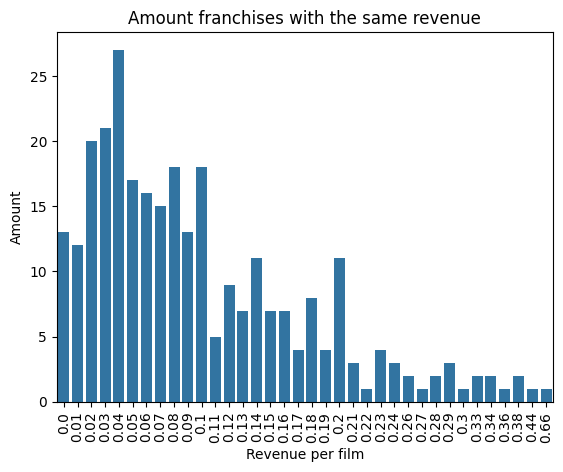

In [21]:
import seaborn as sns


ax = sns.countplot(data=df, x=df['Revenue per film'])
ax.set(title='Amount franchises with the same revenue', ylabel='Amount')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [14]:
# Выведем наиболее успешную франшизу по выручке на 1 фильм
df[df['Revenue per film'] == 0.66]

,Franchise,Total (billions),Releases,First film,Revenue per film
5,Avengers,2.62,4,Avengers: Endgame,0.66


# **Матрица корреляции**

<Axes: >

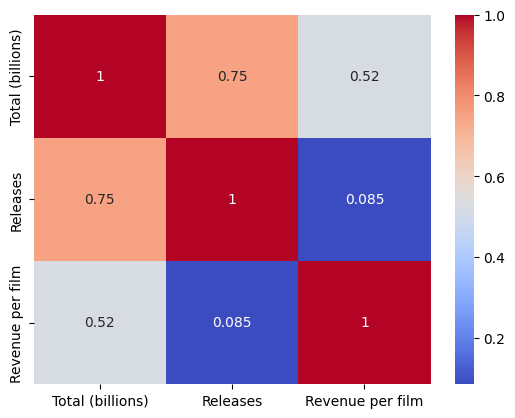

In [23]:
sns.heatmap(data=df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')

Мы считаем линейную корреляцию сильно значимой, если коэффициент корреляции по модулю больше 0.8. Таковых здесь нет, но близкая к сильной корреляция есть между количеством выпущенных продуктов и выручкой франшизы. В целом это логичное утверждение, но как мы видим оно верно не всегда. Например, наиболее успешной франшизой с выручкой на 1 фильм оказалась франшиза с 4 фильмами. Это меньше, чем 75й процентиль. Значит есть достаточное количество франшиз с бОльшим количеством продуктов и меньшей выручкой на фильм

# **Вывод**

In [24]:
# Выведем наиболее успешную франшизу по выручке на 1 фильм
df[df['Revenue per film'] == 0.66]

,Franchise,Total (billions),Releases,First film,Revenue per film
5,Avengers,2.62,4,Avengers: Endgame,0.66
